In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
#mpl.rcParams['font.family'] = 'times new roman'
mpl.rcParams['font.size'] = '25'
mpl.rcParams['xtick.labelsize'] = '25'
mpl.rcParams['ytick.labelsize'] = '25'

In [2]:
from astropy.table import Table
import astropy.units as u
import astropy.constants as c

In [3]:
import sncosmo
from astropy.cosmology import FlatLambdaCDM
import sys
sys.path.append('../tools/')
from dust_extinction import calALambda
from data_binning import data_binning

In [4]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
distmod = cosmo.distmod(z=0.0307)
distmod

<Quantity 35.64481825 mag>

In [5]:
cosmo = FlatLambdaCDM(H0=73, Om0=0.3)
distmod = cosmo.distmod(z=0.0307)
distmod

<Quantity 35.55369415 mag>

In [6]:
z = 0.0307
beta1 = z
beta2 = ((1 + z)**2 - 1) / ((1 + z)**2 + 1)
beta1 * 299792.458, beta2 * 299792.458

(9203.6284606, 9062.417326687751)

In [7]:
DL = np.loadtxt('20jgb_peculiar.dat')[6]  #H0 = 70
#DL = 139.45 #H0 = 67.3
distmod = 5 * np.log10(DL * 1e6 / 10) * u.mag
distmod

<Quantity 35.63665805 mag>

In [8]:
leff_g = 4722.74  #AA
leff_r = 6339.61  #AA
rv = 3.1
ebv = 0.404
calALambda(leff_g, rv, ebv), calALambda(leff_r, rv, ebv)

(1.516916147247459, 1.0017554354796698)

In [11]:
lc = Table.read('ZTF20aayhacx_fnu.csv')
lc['mjd'] = lc['jd'] - 2400000.5
lc['mag'] = np.zeros_like(lc['mjd'])
lc['mag_unc'] = np.zeros_like(lc['mjd'])
lc = lc[np.where((lc['mjd'] > 58950) & (lc['mjd'] < 59100))]

lc_g = lc[lc['passband'] == 'ZTF_g']
lc_r = lc[lc['passband'] == 'ZTF_r']
lc_g['fnu_microJy'] = lc_g['fnu_microJy']
lc_g['fnu_microJy_uncmicroJy'] = lc_g['fnu_microJy_unc']
lc_r['fnu_microJy'] = lc_r['fnu_microJy']
lc_r['fnu_microJy_uncmicroJy'] = lc_r['fnu_microJy_unc']

g_bin = data_binning(
    np.array([lc_g['mjd'], lc_g['fnu_microJy'], lc_g['fnu_microJy_unc']]).T,
    1)
lc_g = dict({
    'mjd': g_bin[:, 0],
    'fnu_microJy': g_bin[:, 1],
    'fnu_microJy_unc': g_bin[:, 2],
    'mag': np.empty_like(g_bin[:, 0]),
    'mag_unc': np.empty_like(g_bin[:, 0]),
    'mag_unc_l': np.empty_like(g_bin[:, 0]),
    'mag_unc_r': np.empty_like(g_bin[:, 0])
})
r_bin = data_binning(
    np.array([lc_r['mjd'], lc_r['fnu_microJy'], lc_r['fnu_microJy_unc']]).T,
    1)
lc_r = dict({
    'mjd': r_bin[:, 0],
    'fnu_microJy': r_bin[:, 1],
    'fnu_microJy_unc': r_bin[:, 2],
    'mag': np.empty_like(r_bin[:, 0]),
    'mag_unc': np.empty_like(r_bin[:, 0]),
    'mag_unc_l': np.empty_like(r_bin[:, 0]),
    'mag_unc_r': np.empty_like(r_bin[:, 0])
})

snr_lim = 2
argg1 = lc_g['fnu_microJy'] > lc_g['fnu_microJy_unc'] * snr_lim
argg2 = lc_g['fnu_microJy'] <= lc_g['fnu_microJy_unc'] * snr_lim
argr1 = lc_r['fnu_microJy'] > lc_r['fnu_microJy_unc'] * snr_lim
argr2 = lc_r['fnu_microJy'] <= lc_r['fnu_microJy_unc'] * snr_lim

In [10]:
arg = lc['fnu_microJy'] > lc['fnu_microJy_unc'] * snr_lim
time = lc[arg]['mjd']
flux = lc[arg]['fnu_microJy']
fluxerr = lc[arg]['fnu_microJy_unc']
zp = np.ones_like(time) * 23.9  #AB magnitude for 1 micro Jansky
zpsys = ['ab' for i in range(len(time))]


def passband(b):
    if b == 'ZTF_g':
        return 'ztfg'
    if b == 'ZTF_r':
        return 'ztfr'
    if b == 'ZTF_i':
        return 'ztfi'


band = [passband(b) for b in lc[arg]['passband']]
data = Table([time, band, flux, fluxerr, zp, zpsys],
             names=['time', 'band', 'flux', 'fluxerr', 'zp', 'zpsys'])

In [24]:
lc_g['mag'][argg1] = -2.5 * np.log10(
    lc_g['fnu_microJy'][argg1]) + 23.9 - distmod.value - calALambda(
        leff_g, rv, ebv)
lc_g['mag'][argg2] = -2.5 * np.log10(
    lc_g['fnu_microJy_unc'][argg2] * 5) + 23.9 - distmod.value - calALambda(
        leff_g, rv, ebv)
lc_g['mag_unc'][argg1] = -2.5 * np.log10(
    (lc_g['fnu_microJy'][argg1] - lc_g['fnu_microJy_unc'][argg1]) /
    (lc_g['fnu_microJy'][argg1] + lc_g['fnu_microJy_unc'][argg1])) / 2
lc_g['mag_unc_l'][argg1] = -2.5 * np.log10(
    (lc_g['fnu_microJy'][argg1] - lc_g['fnu_microJy_unc'][argg1]) /
    (lc_g['fnu_microJy'][argg1]))
lc_g['mag_unc_r'][argg1] = -2.5 * np.log10(
    (lc_g['fnu_microJy'][argg1]) /
    (lc_g['fnu_microJy'][argg1] + lc_g['fnu_microJy_unc'][argg1]))
lc_g['mag_unc'][argg2] = -999
lc_g['mag_unc_l'][argg2] = -999
lc_g['mag_unc_r'][argg2] = -999

lc_r['mag'][argr1] = -2.5 * np.log10(
    lc_r['fnu_microJy'][argr1]) + 23.9 - distmod.value - calALambda(
        leff_r, rv, ebv)
lc_r['mag'][argr2] = -2.5 * np.log10(
    lc_r['fnu_microJy_unc'][argr2] * 5) + 23.9 - distmod.value - calALambda(
        leff_r, rv, ebv)
lc_r['mag_unc'][argr1] = -2.5 * np.log10(
    (lc_r['fnu_microJy'][argr1] - lc_r['fnu_microJy_unc'][argr1]) /
    (lc_r['fnu_microJy'][argr1] + lc_r['fnu_microJy_unc'][argr1])) / 2
lc_r['mag_unc_l'][argr1] = -2.5 * np.log10(
    (lc_r['fnu_microJy'][argr1] - lc_r['fnu_microJy_unc'][argr1]) /
    (lc_r['fnu_microJy'][argr1]))
lc_r['mag_unc_r'][argr1] = -2.5 * np.log10(
    (lc_r['fnu_microJy'][argr1]) /
    (lc_r['fnu_microJy'][argr1] + lc_r['fnu_microJy_unc'][argr1]))
lc_r['mag_unc'][argr2] = -999
lc_r['mag_unc_l'][argr2] = -999
lc_r['mag_unc_r'][argr2] = -999

Text(0, 0.5, '$\\mathrm{Absolute\\ Magnitude}$')

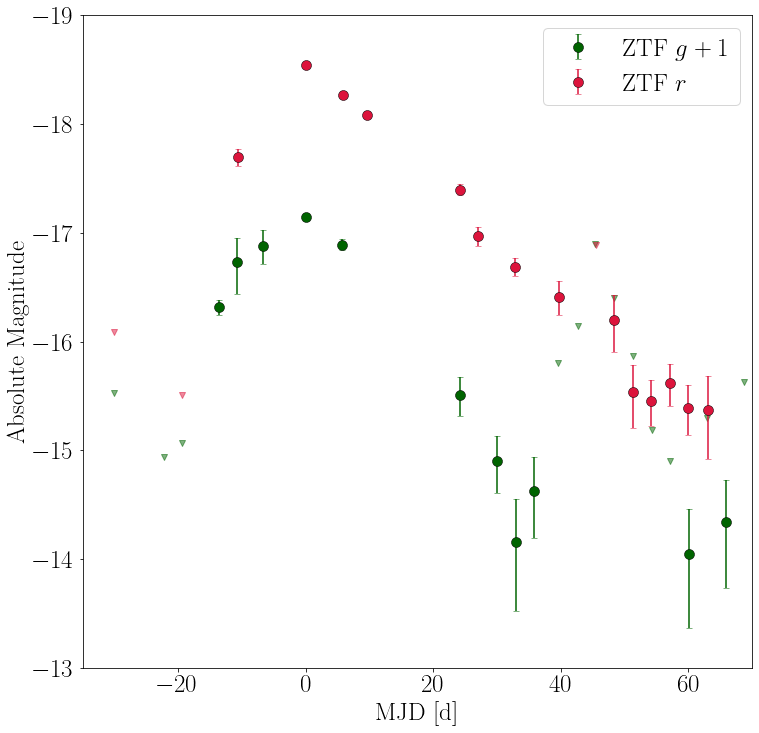

In [25]:
tp = 58986.41

plt.figure(figsize=(12, 12))
plt.errorbar((lc_g['mjd'][argg1] - tp) / (1 + z),
             lc_g['mag'][argg1] + 1,
             yerr=[lc_g['mag_unc_r'][argg1], lc_g['mag_unc_l'][argg1]],
             fmt='o',
             markersize=10,
             capsize=3,
             markeredgecolor='k',
             markeredgewidth=.5,
             color='darkgreen',
             label='$\mathrm{ZTF}\ g+1$')
plt.scatter((lc_g['mjd'][argg2] - tp) / (1 + z),
            lc_g['mag'][argg2] + 1,
            marker='v',
            color='darkgreen',
            alpha=0.5)
plt.errorbar((lc_r['mjd'][argr1] - tp) / (1 + z),
             lc_r['mag'][argr1],
             yerr=[lc_r['mag_unc_r'][argr1], lc_r['mag_unc_l'][argr1]],
             fmt='o',
             markersize=10,
             capsize=3,
             markeredgecolor='k',
             markeredgewidth=.5,
             color='crimson',
             label='$\mathrm{ZTF}\ r$')
plt.scatter((lc_r['mjd'][argr2] - tp) / (1 + z),
            lc_r['mag'][argr2],
            marker='v',
            color='crimson',
            alpha=0.5)
plt.ylim(-19, -13)
plt.xlim(-35, 70)
plt.legend()
plt.gca().invert_yaxis()
plt.xlabel(r'$\mathrm{MJD\ [d]}$')
plt.ylabel(r'$\mathrm{Absolute\ Magnitude}$')

In [26]:
# mjd, mag, mag_unc
# upper limits: mag = 5sigma, mag_unc = -999
X = np.array([lc_g['mjd'], lc_g['mag'], lc_g['mag_unc'], lc_g['mag_unc_r'], lc_g['mag_unc_l']]).T
np.savetxt('SN2020jgb_ZTF_g_snr{:.0f}.dat'.format(snr_lim), X, fmt='%.5f')
Y = np.array([lc_r['mjd'], lc_r['mag'], lc_r['mag_unc'], lc_r['mag_unc_r'], lc_r['mag_unc_l']]).T
np.savetxt('SN2020jgb_ZTF_r_snr{:.0f}.dat'.format(snr_lim), Y, fmt='%.5f')

# SALT2 Fit

In [13]:
# create a model
dust = sncosmo.CCM89Dust()
model = sncosmo.Model(source='salt2',
                      effects=[dust, dust],
                      effect_names=['host', 'mw'],
                      effect_frames=['rest', 'obs'])

# set the model's redshift
model.set(z=0.0307)

# set the model's galactic extinction
model.set(mwebv=0.404)
# run the fit
result, fitted_model = sncosmo.fit_lc(
    data, model, ['t0', 'x0', 'x1', 'c'])  # parameters of model to vary

In [14]:
print("Number of chi^2 function calls:", result.ncall)
print("Number of degrees of freedom in fit:", result.ndof)
print("chi^2 value at minimum:", result.chisq)
print("model parameters:", result.param_names)
print("best-fit values:", result.parameters)
print("The result contains the following attributes:\n", result.keys())

Number of chi^2 function calls: 115
Number of degrees of freedom in fit: 23
chi^2 value at minimum: 258.46125029926515
model parameters: ['z', 't0', 'x0', 'x1', 'c', 'hostebv', 'hostr_v', 'mwebv', 'mwr_v']
best-fit values: [ 3.07000000e-02  5.89836274e+04  1.55109805e-03 -1.04788711e+00
  4.24784600e-01  0.00000000e+00  3.10000000e+00  4.04000000e-01
  3.10000000e+00]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])


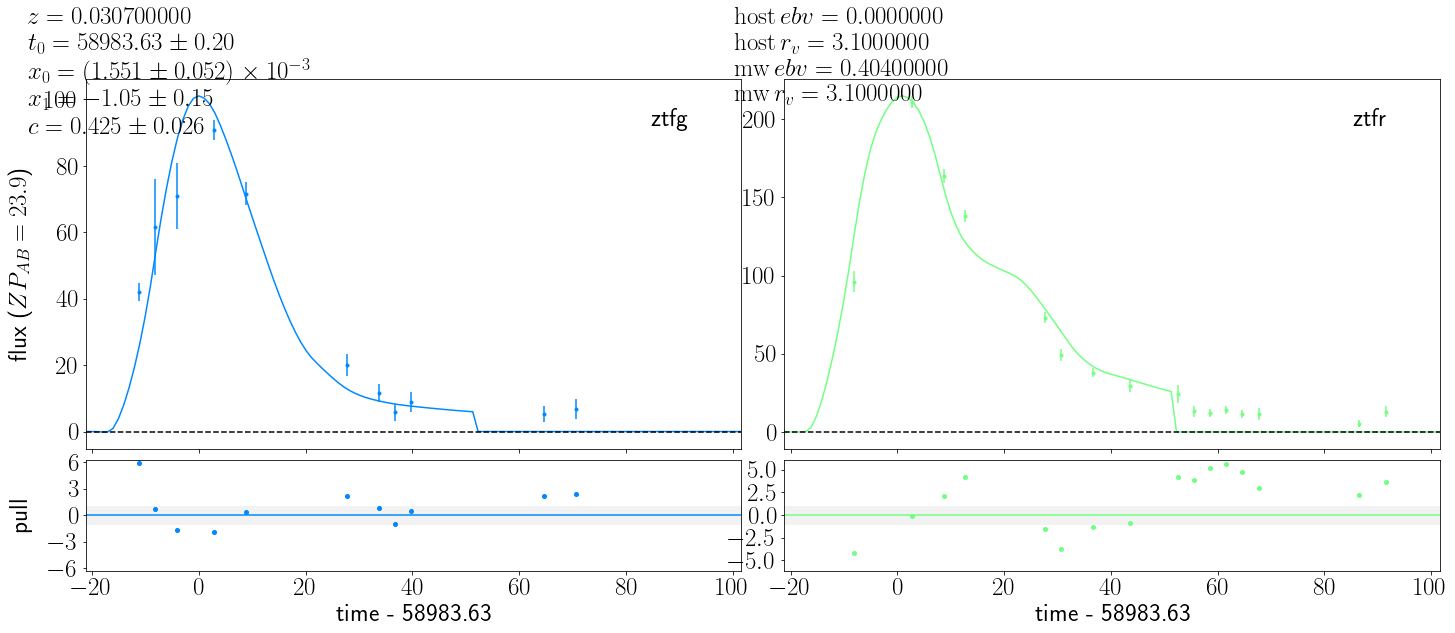

In [15]:
sncosmo.plot_lc(data, model=fitted_model, errors=result.errors, zp=23.9, xfigsize=20);